In [1]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from adaptive_control_gym.envs import DroneEnv
from icecream import ic
from tqdm import trange

/home/pcy/miniconda3/envs/rlgpu/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
gpu_id = 0
loaded_agent = torch.load('/home/pcy/rl/policy-adaptation-survey/results/rl/ppo_ActEx1_CriEx1_S0.pt', map_location=f'cuda:{gpu_id}')
policy = loaded_agent['actor']
adaptor = loaded_agent['adaptor']
compressor = loaded_agent['compressor']
# freeze policy
for p in policy.parameters():
    p.requires_grad = False
device = torch.device("cuda:{}".format(gpu_id) if torch.cuda.is_available() else "cpu")
n_mass = 32 #4
n_decay = 32 #4
n_param = 1 # 4
# env_num = (n_mass ** 3) * (n_decay**3) * (n_param**4)
env_num = (n_mass ) * (n_decay) 
eval_times = 100
ic(env_num)
env = DroneEnv(env_num = env_num, gpu_id=gpu_id)
# mass_x, mass_y, mass_z, decay_x, decay_y, decay_z, param_0, param_1, param_2, param_3
mm_x = torch.linspace(env.mass_min, env.mass_max, n_mass, device=device)
# mm_y = torch.linspace(env.mass_min, env.mass_max, n_mass, device=device)
# mm_z = torch.linspace(env.mass_min, env.mass_max, n_mass, device=device)
dd_x = torch.linspace(env.decay_min, env.decay_max, n_decay, device=device)
# dd_y = torch.linspace(env.decay_min, env.decay_max, n_decay, device=device)
# dd_z = torch.linspace(env.decay_min, env.decay_max, n_decay, device=device)
# pp_0 = torch.linspace(env.res_dyn_param_min, env.res_dyn_param_max, n_param, device=device)
# pp_1 = torch.linspace(env.res_dyn_param_min, env.res_dyn_param_max, n_param, device=device)
# pp_2 = torch.linspace(env.res_dyn_param_min, env.res_dyn_param_max, n_param, device=device)
# pp_3 = torch.linspace(env.res_dyn_param_min, env.res_dyn_param_max, n_param, device=device)
pp_0 = torch.zeros(1, device=device)
pp_1 = torch.zeros(1, device=device)
pp_2 = torch.zeros(1, device=device)
pp_3 = torch.zeros(1, device=device)
# create meshgrid
# mm_x, mm_y, mm_z, dd_x, dd_y, dd_z, pp_0, pp_1, pp_2, pp_3 = torch.meshgrid(mm_x, mm_y, mm_z, dd_x, dd_y, dd_z, pp_0, pp_1, pp_2, pp_3)
mm_x, dd_x, pp_0, pp_1, pp_2, pp_3 = torch.meshgrid(mm_x,dd_x,pp_0, pp_1, pp_2, pp_3)
# flatten
# mm_x, mm_y, mm_z, dd_x, dd_y, dd_z, pp_0, pp_1, pp_2, pp_3 = mm_x.reshape(-1), mm_y.reshape(-1), mm_z.reshape(-1), dd_x.reshape(-1), dd_y.reshape(-1), dd_z.reshape(-1), pp_0.reshape(-1), pp_1.reshape(-1), pp_2.reshape(-1), pp_3.reshape(-1)
mm_x, mm_y, mm_z, dd_x, dd_y, dd_z, pp_0, pp_1, pp_2, pp_3 = mm_x.reshape(-1), mm_x.reshape(-1), mm_x.reshape(-1), dd_x.reshape(-1), dd_x.reshape(-1), dd_x.reshape(-1), pp_0.reshape(-1), pp_1.reshape(-1), pp_2.reshape(-1), pp_3.reshape(-1)
# concat
mass = torch.stack([mm_x, mm_y, mm_z], dim=-1)
decay = torch.stack([dd_x, dd_y, dd_z], dim=-1)
res_dyn_param = torch.stack([pp_0, pp_1, pp_2, pp_3], dim=-1)
all_params = torch.cat([mass, decay, res_dyn_param], dim=-1)
# evaluate env
rews = torch.zeros((env_num, eval_times), device=device)
for i in trange(eval_times):
    state, info = env.reset()
    # env.mass, env.decay, env.res_dyn_param = mass, decay, res_dyn_param
    env.mass, env.decay = mass, decay
    for t in range(env.max_steps-1):
        act = policy(state, compressor(info['e']))
        state, reward, done, info = env.step(act)
        rews[:, i] += reward
rews /= env.max_steps
rews_mean, rews_std = rews.mean(dim=-1), rews.std(dim=-1)
# concat all params and rews
all_params = torch.cat([all_params, rews_mean.unsqueeze(-1), rews_std.unsqueeze(-1)], dim=-1)
header_list = ['mass_x', 'mass_y', 'mass_z', 'decay_x', 'decay_y', 'decay_z', 'param_0', 'param_1', 'param_2', 'param_3', 'rew_mean', 'rew_std']
df = pd.DataFrame(all_params.cpu().numpy(), columns=header_list)
df.to_csv('results/eval_expert.csv', index=False)

ic| env_num: 1024
100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


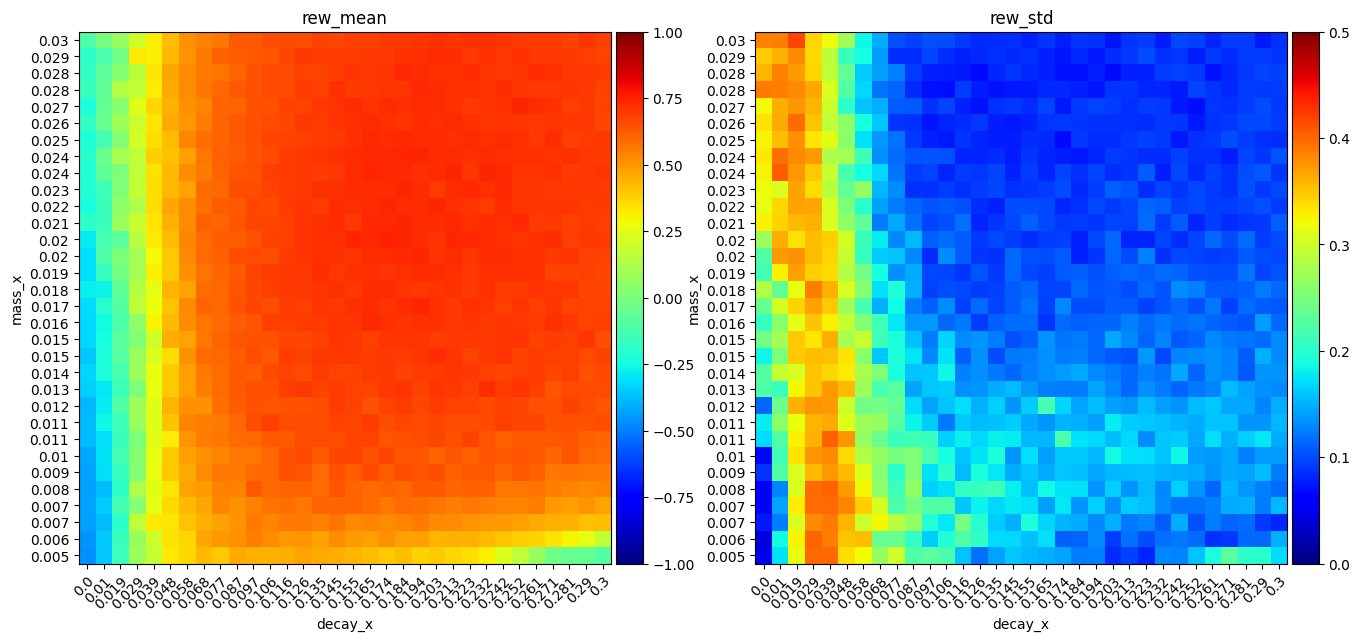

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
# plot rew_mean and reward_std regarding mass_x and decay_x as heatmap
df = pd.read_csv('results/eval_expert.csv')
df = df.sort_values(by=['mass_x', 'decay_x'])
df = df.reset_index(drop=True)
# df_small = pd.read_csv('results/eval_small.csv')
# df_small = df_small.sort_values(by=['mass_x', 'decay_x'])
# df_small = df_small.reset_index(drop=True)
# df['rew_mean'] -= df_small['rew_mean']
rew_mean = df['rew_mean'].values.reshape(n_mass, n_decay)
rew_std = df['rew_std'].values.reshape(n_mass, n_decay)
mass_x = df['mass_x'].values.reshape(n_mass, n_decay)
decay_x = df['decay_x'].values.reshape(n_mass, n_decay)
# plot
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# set cmap range from -1 to 1
im = ax[0].imshow(rew_mean, vmin=-1, vmax=1, cmap='jet', origin='lower')
ax[0].set_aspect('equal')
ax[0].set_xlabel('decay_x')
ax[0].set_ylabel('mass_x')
ax[0].set_title('rew_mean')
# add colorbar for ax[0]
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[0].images[0], cax=cax)
# add xticks and yticks
ax[0].set_xticks(np.arange(n_decay))
ax[0].set_xticklabels(np.round(decay_x[0], 3))
ax[0].set_yticks(np.arange(n_mass))
ax[0].set_yticklabels(np.round(mass_x[:, 0], 3))
# set xticks to be vertical
plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax[1].imshow(rew_std, vmin=0.0, vmax=0.5, cmap='jet', origin='lower')
ax[1].set_xlabel('decay_x')
ax[1].set_ylabel('mass_x')
ax[1].set_title('rew_std')
# add colorbar for ax[0]
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[1].images[0], cax=cax)
# add xticks and yticks
ax[1].set_xticks(np.arange(n_decay))
ax[1].set_xticklabels(np.round(decay_x[0], 3))
ax[1].set_yticks(np.arange(n_mass))
ax[1].set_yticklabels(np.round(mass_x[:, 0], 3))
# set xticks to be vertical
plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

ValueError: Could not interpret value `rew` for parameter `y`

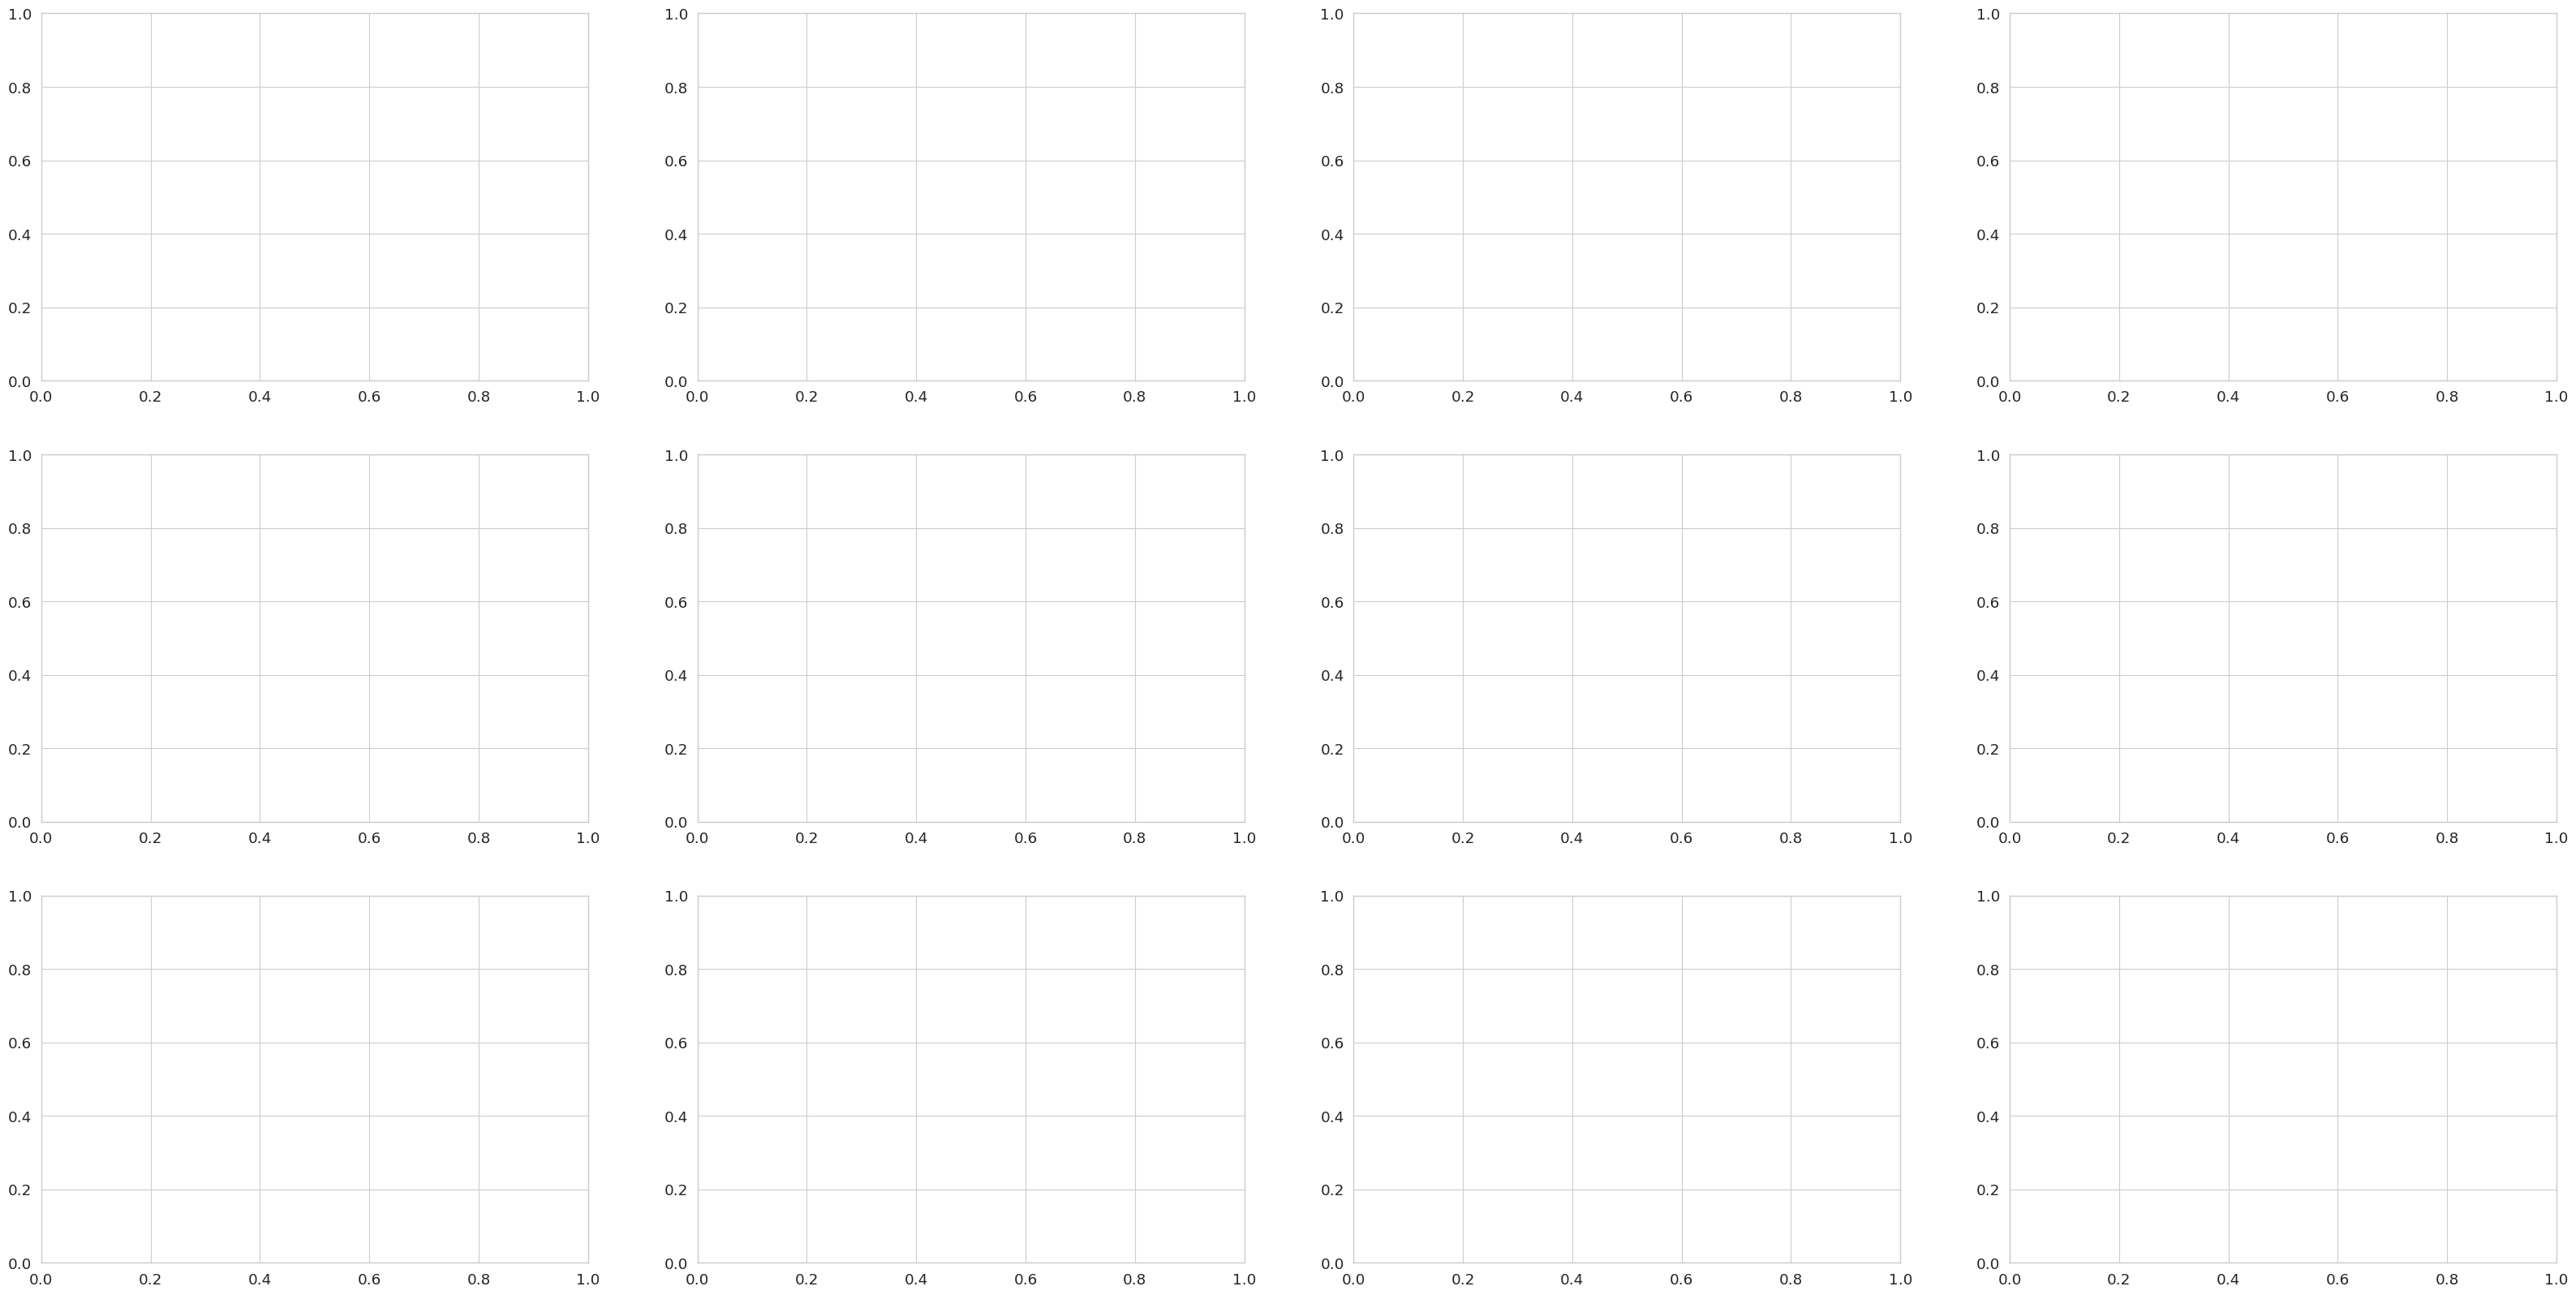

In [13]:
# read the file
df = pd.read_csv('results/eval.csv')
# use seaborn to plot
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
# plot
fig, axs = plt.subplots(3, 4, figsize=(40, 20))
sns.lineplot(x='mass_x', y='rew', data=df, ax=axs[0,0])
sns.lineplot(x='mass_y', y='rew', data=df, ax=axs[0,1])
sns.lineplot(x='mass_z', y='rew', data=df, ax=axs[0,2])
sns.lineplot(x='decay_x', y='rew', data=df, ax=axs[1,0])
sns.lineplot(x='decay_y', y='rew', data=df, ax=axs[1,1])
sns.lineplot(x='decay_z', y='rew', data=df, ax=axs[1,2])
sns.lineplot(x='param_0', y='rew', data=df, ax=axs[2,0])
sns.lineplot(x='param_1', y='rew', data=df, ax=axs[2,1])
sns.lineplot(x='param_2', y='rew', data=df, ax=axs[2,2])
sns.lineplot(x='param_3', y='rew', data=df, ax=axs[2,3])
# save the plot
plt.savefig('results/sensitivity.png')